# Background tests for data formatting

## floating point error
Can we use 16-bit floats to represent waveform data with acceptable accuracy?

/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_12800/3732100003.py:16: RuntimeWarning: overflow encountered in cast
  x_uint = x.astype(as_dtype).view(uint_type)
/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_12800/3732100003.py:17: RuntimeWarning: invalid value encountered in subtract
  return (x_uint+uint_type.type(1)).view(as_dtype).astype(np.float64) - x.astype(np.float64)


(-150.0, 286.0)

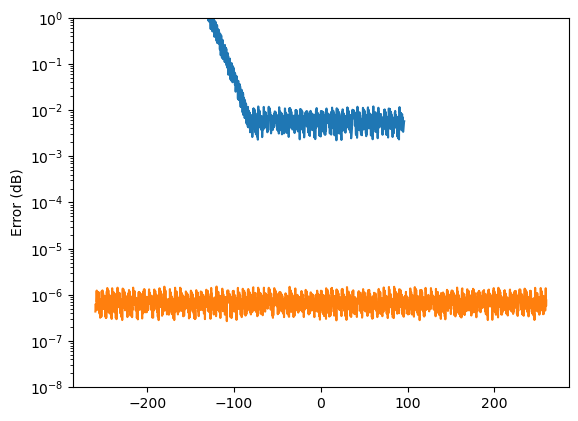

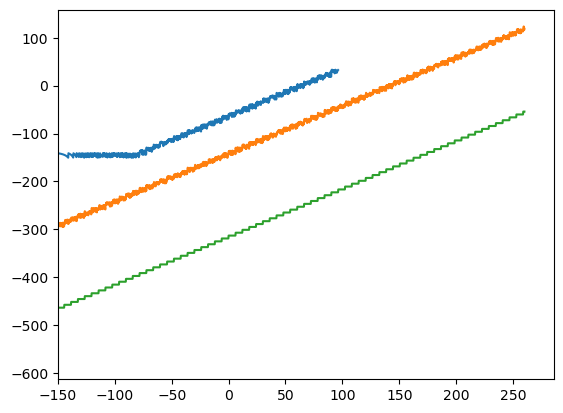

In [45]:
from __future__ import annotations
import numpy as np
from matplotlib import pyplot as plt

def bitwise_step(x: np.array[np.float16|np.float32], as_dtype=np.float16):
    as_dtype = np.dtype(as_dtype)
    if as_dtype == np.dtype('float16'):
        uint_type = np.dtype('uint16')
    elif as_dtype == np.dtype('float32'):
        uint_type = np.dtype('uint32')
    elif as_dtype == np.dtype('float64'):
        uint_type = np.dtype('uint64')
    else:
        raise TypeError('unrecognized type ', as_dtype)

    x_uint = x.astype(as_dtype).view(uint_type)
    return (x_uint+uint_type.type(1)).view(as_dtype).astype(np.float64) - x.astype(np.float64)

x = (np.logspace(-13,13,26*100+1,dtype=np.float64))
err16 = bitwise_step(x, np.float16)
err32 = bitwise_step(x, np.float32)
err64 = bitwise_step(x, np.float64)

fig, ax = plt.subplots()
for name, err in (('float16', err16), ('float32', err32), ('float64', err64)):
    ax.plot(20*np.log10(x), 20*np.log10((x+err)/x), label=name)
# plt.xlim([-150,None])
ax.set_ylim([1e-8,1])
ax.set_yscale('log')
ax.set_ylabel('Error (dB)')

fig, ax = plt.subplots()
for name, err in (('float16', err16), ('float32', err32), ('float64', err64)):
    ax.plot(20*np.log10(x), 20*np.log10(err), label=name)
ax.set_xlim([-150,None])

### What is the spectral-domain impact?

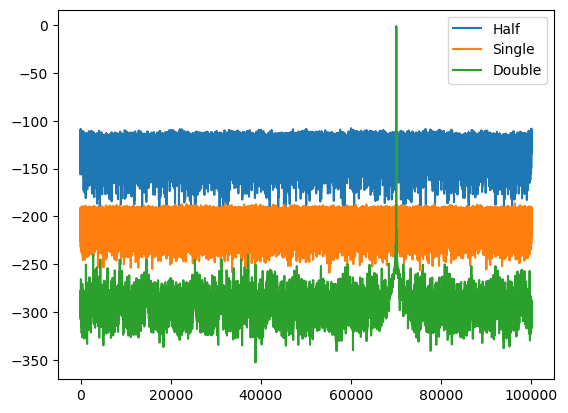

In [102]:
import scipy

fs = 1e3
fmod = 0.2e3
t = np.arange(int(1e5), dtype='float64')/fs
x = np.exp(2j*np.pi*fmod*t + np.pi/2).astype('complex128')/np.sqrt(2)
x *= scipy.signal.get_window(('dpss', 8), x.size)

x16 = (x.view('float64').astype('float16')).astype('float64').view('complex128')
x32 = (x.view('float64').astype('float32')).astype('float64').view('complex128')

X = scipy.fft.fftshift(scipy.fft.fft(x))/x.size
X16 = scipy.fft.fftshift(scipy.fft.fft(x16))/x.size
X32 = scipy.fft.fftshift(scipy.fft.fft(x32))/x.size
X16[X16 == 0] = 1e-20

fig, ax = plt.subplots()

ax.plot(20*np.log10(np.abs(X16)), label='Half')
ax.plot(20*np.log10(np.abs(X32)), label='Single')
ax.plot(20*np.log10(np.abs(X)), label='Double')
ax.legend()
# ax.set_ylim([1e-8,1])
# ax.set_yscale('log')
# ax.set_ylabel('Error (dB)')

# fig, ax = plt.subplots()
# for name, err in (('float16', err16), ('float32', err32)):
#     ax.plot(20*np.log10(x), 20*np.log10(err), label=name)
# ax.set_xlim([-150,None])